# Experiment settings — documentation

This notebook centralizes experiment configuration (edit these values at the top):

- `RANDOM_STATE_LIST`: list of seeds used as repeated experiments (treat seeds as repeated draws).
- `DATASET_N_CLUSTERS`: optional mapping dataset -> number of clusters for CLID (override heuristic when you know the right K).
- `BOOTSTRAP_B`: bootstrap resample count (used when group counts are small).
- `BOOTSTRAP_THRESHOLD`: if a group has count <= this threshold, the code uses bootstrap percentile CI instead of analytic SEM.

How to use:
- Edit the Python configuration cell below (not this markdown) to change seeds, cluster choices and bootstrap params.
- Run the "smoke test" cell (added later) to validate changes quickly on a small dataset (Iris).


In [361]:
# Experiment configuration (edit these values to control the whole notebook)
# - RANDOM_STATE_LIST: list of random seeds / repeat experiments
# - DATASET_N_CLUSTERS: dataset-specific number of clusters for CLID computation
# - BOOTSTRAP_B: number of bootstrap resamples used when group counts are small
# - BOOTSTRAP_THRESHOLD: groups with count <= this value use bootstrap CI

RANDOM_STATE_LIST = [42, 62, 109,  152, 235, 318, 421, 512, 613, 714, 815, 912, 1017,2033,3123]
# 12 random seeds as specified in the report

BOOTSTRAP_B = 500
BOOTSTRAP_THRESHOLD = 3

# Dataset-specific cluster choices (override when you know a sensible K for a dataset)
DATASET_N_CLUSTERS = {
    'Iris': 3,
    'Wine': 3,
    'Breast Cancer': 2,
    'Digits': 10,
    'Olivetti Faces': 40,
    'Synthetic Clusters': 5,
    'German Credit': 3
}

# Output paths (change if you want CSVs and plots saved elsewhere)
OUTPUT_DIR = "results"


In [362]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import seaborn as sns
import warnings
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from itertools import product
import optuna
import os
from typing import Dict, List, Tuple, Any
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kendalltau, spearmanr
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_olivetti_faces
from sklearn.datasets import load_digits
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
display(HTML("<style>.output_scroll {height: 300px; overflow-y: scroll;}</style>"))
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'sans-serif',
    'font.size': 12
})

## 1. Research Objectives and Background
Project Supervisor: Louis Ohl louis.ohl@liu.se

Recommended pre-requisite courses: 732A83, 732A870, 732A99, 732A82


The growth of representation learning methods, e.g. SIMCLR, DINO, is a milestone of the recent deep learning achievements in self-supervised learning, providing generic features that can be repurposed for downstream tasks. However, one of the main mean of evaluation for these models remain the ability to perform downstream tasks, notably with post-hoc classification. Few works have proposed instead scoring methods to evaluate the features per se: RankMe, CLID, or alignment to name a few.


The goal of this research project is to assess those different internal metrics on dimension reduction contexts. Dimension reduction is the first basic tool used for visualisation, but it can also be used to simply to provide an alternative representation of the dataset at any lower dimension.


The selected student is expected to implement CLID, Rankme, or any other score of choice and evaluate their applicability on different dimension reduction techniques: PCA, TSNE and UMAP. Datasets will be free to choose among UCI tabular datasets.


1. Wang, T., & Isola, P. (2020, November). Understanding contrastive representation learning through alignment and uniformity on the hypersphere. In International conference on machine learning (pp. 9929-9939). PMLR.

2. Garrido, Q., Balestriero, R., Najman, L., & Lecun, Y. (2023, July). Rankme: Assessing the downstream performance of pretrained self-supervised representations by their rank. In International conference on machine learning (pp. 10929-10974). PMLR.

3. Lu, Y., Liu, Z., Baratin, A., Laroche, R., Courville, A., & Sordoni, A. Using Representation Expressiveness and Learnability to Evaluate Self-Supervised Learning Methods. Transactions on Machine Learning Research.

## 2. Datasets
We try to evaluate the intric metric using the data of different dimensions, below dataset from UCI is selected applying to our experiment. 
- Wine (13D), Breast Cancer (30D), Digits (64D), Olivetti Faces (400D)
- All data are standardized.

In [363]:
def load_datasets():
    """
    Load multiple UCI datasets for dimensionality reduction evaluation.
    
    Returns:
    --------
    datasets : dict
        Dictionary containing dataset name as key and data/target as value
    """
    datasets = {}
    
    # 1. Iris dataset (4D, 150 samples, 3 classes)
    iris = load_iris()
    datasets['Iris'] = {
        'data': iris.data,
        'target': iris.target,
        'feature_names': iris.feature_names,
        'target_names': iris.target_names
    }
    
    # 2. Wine dataset (13D, 178 samples, 3 classes)
    wine = load_wine()
    datasets['Wine'] = {
        'data': wine.data,
        'target': wine.target,
        'feature_names': wine.feature_names,
        'target_names': wine.target_names
    }
    
    # 3. Breast Cancer dataset (30D, 569 samples, 2 classes)
    cancer = load_breast_cancer()
    datasets['Breast Cancer'] = {
        'data': cancer.data,
        'target': cancer.target,
        'feature_names': cancer.feature_names,
        'target_names': cancer.target_names
    }
    
    # 4. Digits dataset (64D, 1797 samples, 10 classes)
    digits = load_digits()
    datasets['Digits'] = {
        'data': digits.data,
        'target': digits.target,
        'feature_names': [f'pixel_{i}' for i in range(64)],
        'target_names': digits.target_names
    }
    
    # 5. Olivetti Faces dataset (4096D -> 400D via PCA, 400 samples, 40 classes)
    try:
        faces = fetch_olivetti_faces(shuffle=True, random_state=42)
        # Reduce to 400D using PCA to make it manageable
        # from sklearn.decomposition import PCA
        # pca = PCA(n_components=400, random_state=42)
        # faces_reduced = pca.fit_transform(faces.data)
        datasets['Olivetti Faces'] = {
            'data': faces.data,
            'target': faces.target,
            'target_names': [f'person_{i}' for i in range(40)]
        }
    except Exception as e:
        print(f"Failed to load Olivetti Faces: {e}")
    
    # 6. Synthetic Clusters (20D, 1000 samples, 5 clusters)
    X_synthetic, y_synthetic = make_blobs(
        n_samples=1000,
        n_features=20,
        centers=5,
        cluster_std=1.0,
        random_state=42
    )
    datasets['Synthetic Clusters'] = {
        'data': X_synthetic,
        'target': y_synthetic,
        'feature_names': [f'feature_{i}' for i in range(20)],
        'target_names': [f'cluster_{i}' for i in range(5)]
    }
    
    # 7. German Credit dataset (20D, 1000 samples, 2 classes)
    try:
        # Try to load from OpenML
        credit = fetch_openml('credit-g', version=1, as_frame=False, parser='auto')
        # Convert categorical features to numerical
        from sklearn.preprocessing import LabelEncoder
        X_credit = credit.data
        y_credit = credit.target
        
        # Encode target
        le = LabelEncoder()
        y_credit_encoded = le.fit_transform(y_credit)
        
        datasets['German Credit'] = {
            'data': X_credit,
            'target': y_credit_encoded,
            'feature_names': credit.feature_names if hasattr(credit, 'feature_names') else [f'feature_{i}' for i in range(X_credit.shape[1])],
            'target_names': ['good', 'bad']
        }
    except Exception as e:
        print(f"Failed to load German Credit dataset: {e}")
        print("Continuing without German Credit dataset...")
    
    return datasets


def preprocess_data(data):
    """
    Standardize the input data using StandardScaler.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data matrix
        
    Returns:
    --------
    data_standardized : numpy.ndarray
        Standardized data with zero mean and unit variance
    """
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data)
    return data_standardized

## 3. Methods
- **Dimensionality reduction**: PCA, t-SNE, UMAP, with parameter grids automatically adapted to data shape.
- **Internal metrics**: RankMe, CLID.
- **Classification evaluation**: Logistic Regression on reduced features, recording accuracy.
- **Parameter optimization**: Fixed parameters to avoid confounding factors, multiple random seeds for robustness.
- **Correlation analysis**: Analyzes the relationship between internal metrics and classification accuracy.

In [364]:


def rankme(embeddings, epsilon=1e-12):
    """
    Compute the RankMe score using the singular values of the embedding matrix.

    This follows the idea in Garrido et al. (2023): use the singular values
    of the representation matrix (or covariance if SVD on the matrix fails),
    normalize them to form a probability distribution, compute Shannon entropy
    and return exp(entropy) as the RankMe value.

    Parameters
    ----------
    embeddings : array-like, shape (n_samples, n_features)
        Embedding matrix where each row is a sample vector.
    epsilon : float
        Numerical stability constant to avoid log(0).

    Returns
    -------
    rankme_value : float
        RankMe score (>= 0). Higher means effectively higher rank/expressiveness.
        Returns np.nan if computation fails due to insufficient data or SVD errors.
    """
    try:
        embeddings = np.asarray(embeddings, dtype=float)
        
        # Handle trivial cases - return NaN instead of raising
        if embeddings.size == 0:
            return np.nan
        
        # If there is only one sample or one feature, return NaN
        if embeddings.shape[0] <= 1 or embeddings.shape[1] == 0:
            return np.nan

        # Compute singular values of the embedding matrix
        # Wrap in try-except to catch SVD convergence failures
        try:
            s = np.linalg.svd(embeddings, compute_uv=False)
        except (np.linalg.LinAlgError, ValueError) as e:
            # SVD failed (e.g., convergence issues, numerical instability)
            return np.nan

        s = np.abs(s)
        s = s[s > epsilon]
        
        # If no valid singular values remain, return NaN
        if s.size == 0:
            return np.nan

        pk = s / (np.sum(s) + epsilon)
        entropy = -np.sum(pk * np.log(pk + epsilon))
        rankme_value = float(np.exp(entropy))
        
        # Final sanity check
        if not np.isfinite(rankme_value):
            return np.nan
            
        return rankme_value
        
    except Exception as e:
        # Catch any other unexpected errors and return NaN
        # This ensures the pipeline continues even if something unexpected happens
        return np.nan


In [365]:
def estimate_intrinsic_dimension(Z, metric="euclidean"):
    D = pairwise_distances(Z, metric=metric)
    np.fill_diagonal(D, np.inf) # set the self-distance to inf
    r_sorted = np.sort(D, axis=1)
    r1, r2 = r_sorted[:, 0], r_sorted[:, 1]
    mu = r2/r1
    mu = mu[np.isfinite(mu) & (mu > 1.0)]
    mu_sorted = np.sort(mu)
    N = len(mu_sorted)
    F_emp = np.arange(1, N + 1) / N

    x = np.log(mu_sorted)
    y = -np.log(1 - F_emp + 1e-10)
    slope, _ = np.polyfit(x, y, 1)
    return slope



In [366]:
def cluster_learnability(Z, n_clusters=None, k=5, metric="euclidean", random_state=42):
    """
    Estimate cluster learnability using KMeans + KNN classification accuracy.

    If `n_clusters` is provided (int), use it. Otherwise use a simple heuristic based
    on number of samples: default = max(2, N // 10).
    """
    N = len(Z)

    # Ensure we have enough samples
    if N < 10:
        raise ValueError("Not enough samples to compute cluster learnability.")

    # If caller provided n_clusters explicitly, use it; else derive from N
    if n_clusters is None:
        n_clusters = max(2, N // 10)
    else:
        # ensure it's at least 2 and not more than number of samples
        n_clusters = int(max(2, min(n_clusters, max(2, N))))

    # Generate pseudo-labels using KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    pseudo_labels = kmeans.fit_predict(Z)

    rng = np.random.RandomState(random_state)
    idx = np.arange(N)
    rng.shuffle(idx)
    split = int(0.8 * N)
    train_idx, val_idx = idx[:split], idx[split:]

    # Ensure we have validation samples
    if len(val_idx) == 0:
        raise ValueError("Not enough samples for validation split.")

    # Determine k for KNN (must be less than training set size)
    k = min(k, len(train_idx) - 1)
    if k < 1:
        k = 1

    # Train KNN on pseudo-labels and evaluate
    try:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(Z[train_idx], pseudo_labels[train_idx])
        pred = knn.predict(Z[val_idx])
        acc = accuracy_score(pseudo_labels[val_idx], pred)
        return acc
    except Exception as e:
        raise ValueError(f"Failed to compute cluster learnability due to an error: {e}")


def clid_score_cross_models(embeddings_dict: Dict[str, np.ndarray], n_clusters=None):
    """
    Compute CLID scores for a dict of embeddings.

    - embeddings_dict: mapping key -> embedding array (n_samples, n_features)
      Keys should be unique identifiers
    - n_clusters: either None (use heuristic per embedding) or an int to force the
      same number of clusters for all embeddings.

    Returns a dict mapping same keys to CLID values (float) or np.nan on failure.
    """
    CL_vals = []
    ID_vals = []
    keys = []
    CLID_dict = {}

    for emb_name, emb in embeddings_dict.items():
        keys.append(emb_name)
        try:
            cl = cluster_learnability(emb, n_clusters=n_clusters)
        except Exception:
            cl = np.nan
        try:
            id_est = estimate_intrinsic_dimension(emb)
        except Exception:
            id_est = np.nan
        CL_vals.append(cl)
        ID_vals.append(id_est)

    CL_vals = np.array(CL_vals, dtype=float)
    ID_vals = np.array(ID_vals, dtype=float)

    def minmax_norm(arr):
        valid = ~np.isnan(arr)
        if not valid.any():
            return np.full_like(arr, np.nan, dtype=float)
        mn = np.nanmin(arr)
        mx = np.nanmax(arr)
        if np.isclose(mx, mn):
            # all equal -> return constant mid value
            out = np.full_like(arr, 0.5, dtype=float)
            out[~valid] = np.nan
            return out
        out = (arr - mn) / (mx - mn)
        out[~valid] = np.nan
        return out

    CL_norm = minmax_norm(CL_vals)
    ID_norm = minmax_norm(ID_vals)

    CLID_vals = CL_norm + ID_norm

    for k, v in zip(keys, CLID_vals):
        CLID_dict[k] = float(v) if np.isfinite(v) else np.nan

    return CLID_dict


In [367]:

def classification_evaluation(embeddings, labels, cv=5, random_state=42):
    """
    Evaluate classification performance using StratifiedKFold cross-validation.
    only use Logistic Regression to prevent from intrdoducing too much variance.
    """
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    # fixed: only use Logistic Regression
    clf =  LogisticRegression(
            random_state=random_state, 
            solver='lbfgs',
            max_iter=1000)
    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
   # for clf_name, clf in classifiers.items():
    cv_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    for train_idx, test_idx in skf.split(embeddings, labels_encoded):
        X_train, X_test = embeddings[train_idx], embeddings[test_idx]
        y_train, y_test = labels_encoded[train_idx], labels_encoded[test_idx]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cv_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
    mean_score = np.mean(cv_scores)        
    results['accuracy'] = mean_score
    results['classifier'] = "Logistic Regression"
    results[f'f1'] = np.mean(f1_scores)
    results[f'recall'] = np.mean(recall_scores)
    return results


def comprehensive_evaluation_with_classification(embedding, labels, name="Unknown", print_results=False):
         
    results = {}
    
    try:
        # 1. RankMe: Representation quality metric (Garrido et al., 2023)
        results['rankme'] = rankme(embedding)
        
        # 2. Uniformity: Distribution uniformity on hypersphere (Wang et al., 2020)
        # try:
        #     results['uniformity'] = uniformity(embeddings, t=2)
        # except Exception as e:
        #     if print_results:
        #         print(f"Warning: Failed to compute uniformity for {name}: {e}")
        #     results['uniformity'] = np.nan

        # 3. Classification performance
        if labels is not None and len(np.unique(labels)) > 1:
            classification_results = classification_evaluation(embedding, labels)
            results.update(classification_results)

    except Exception as e:
        print(f"Error during evaluation of {name}: {e}")
    
    return results

In [368]:

def apply_dimension_reduction(data, method='pca', **params):
    """
    Apply different dimension reduction techniques.

    Key change: do not bootstrap-resample the data when performing PCA.
    Treat random_state only as the randomness source for inherently randomized
    algorithms (e.g., t-SNE, UMAP, or PCA with svd_solver='randomized').

    Parameters:
    -----------
    data : numpy.ndarray
    method : str
        reduction method: 'pca', 'tsne', 'umap'
    n_components : int
    **kwargs : dict
    Returns:
    --------
    reduced_data : numpy.ndarray
    """

    method = method.lower()
    if method == 'pca':
        # Respect caller-provided svd_solver (default to 'auto')
        svd_solver = params.get('svd_solver', 'auto')
        n_components = params.get('n_components', None)
        whiten = params.get('whiten', False)
        # Only pass random_state when using randomized SVD
        if svd_solver == 'randomized':
            pca = PCA(n_components=n_components, svd_solver=svd_solver,
                      random_state=params.get('random_state', None), whiten=whiten)
        else:
            pca = PCA(n_components=n_components, svd_solver=svd_solver, whiten=whiten)
        return pca.fit_transform(data)

    elif method == 'tsne':
        tsne_params = params.copy()
        if 'tsne_method' in tsne_params:
            tsne_params['method'] = tsne_params.pop('tsne_method')
        reducer = TSNE(**tsne_params)
        return reducer.fit_transform(data)

    elif method == 'umap':
        reducer = umap.UMAP(**params)
        return reducer.fit_transform(data)

    else:
        raise ValueError(f"Applying an unknown method: {method}")


## 3.2 Apply bayesian search and grid search to see What happened under different hyperparameter

In [369]:
def get_fixed_parameters(method,random_state_list = [42, 52, 62, 72, 82], n_components=2, n_samples=None):
    '''
    Get fixed parameters for different dimension reduction methods.
    '''
    params_list = []
    for random_state in random_state_list:


        if method.lower() == 'pca':
            params_list.append({
                'n_components': n_components,
                'whiten': False,
                'svd_solver': 'randomized',
                'random_state': random_state
            })
        
        elif method.lower() == 'tsne':
     
            if n_components > 3:
                # Barnes-Hut doesn't support >3D, must use exact
                tsne_method = 'exact'
            elif n_samples is not None and n_samples < 500:
                # Small dataset + low dimension: exact is fine
                tsne_method = 'exact'
            else:
                # Large dataset + low dimension (≤3D): use barnes_hut
                tsne_method = 'barnes_hut'
            
            # Note: t-SNE is traditionally used for 2D/3D visualization,
            # but sklearn's exact method supports higher dimensions for research purposes
            params_list.append({
                'n_components': n_components,
                'perplexity': min(30, max(5, (n_samples // 4) if n_samples else 30)),  # Adaptive perplexity
                'learning_rate': 200,
                'n_iter': 1000,
                'init': 'random', # if init == 'pca', random_state is used internally
                'random_state': random_state,
                'tsne_method': tsne_method
            })
        
        elif method.lower() == 'umap':
            params_list.append({    
                'n_components': n_components,
                'n_neighbors': 15,
                'min_dist': 0.1,
                'metric': 'euclidean',
                'random_state': random_state
            })
        
        else:
            raise ValueError(f"Unknown method: {method}")
        
    return params_list

In [370]:
def compute_cross_method_correlations(results,eval_metrics = ['rankme', 'clid']):
    """
    Compute correlation coefficients between evaluation metrics and classification accuracy
    across different dimension reduction methods at fixed embedding dimensions.

    Key change: first aggregate multiple seeds per (dataset, method, n_components)
    by taking the mean (and keeping std/count), then compute correlations across
    methods using the aggregated values. This avoids treating different seeds as
    independent methods (which would bias correlations).
    """

    # transform results to DataFrame
    df_data = []
    for result in results:
        dataset = result.get('dataset', 'Unknown')
        method = result.get('method', 'unknown')
        n_components = int(result.get('n_components', 0)) if result.get('n_components', None) is not None else 0
        df_data.append({
            'dataset': dataset,
            'method': method,
            'n_components': n_components,
            'rankme': result.get('rankme', np.nan),
            'clid': result.get('clid', np.nan),
            'accuracy': result.get('accuracy', np.nan),
            'seed': result.get('seed', np.nan)
        })

    if not df_data or len(df_data) == 0:
        raise ValueError("No data available to compute correlations.")

    df = pd.DataFrame(df_data)

    available_metrics = [m for m in eval_metrics if m in df.columns and df[m].notna().sum() > 0]
    if not available_metrics:
        raise ValueError("No available evaluation metrics found.")

    # Aggregate seeds: compute mean/std/count per (dataset, method, n_components)
    agg_funcs = {'accuracy': ['mean', 'std', 'count']}
    for m in available_metrics:
        agg_funcs[m] = ['mean', 'std', 'count']

    grouped = df.groupby(['dataset', 'method', 'n_components']).agg(agg_funcs)
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped = grouped.reset_index()

    correlation_results = []

    print("Correlation Analysis (Aggregated over seeds, Comparing Different Methods)")

    # For each dataset and dimension, compute correlation across methods using aggregated means
    for dataset in grouped['dataset'].unique():
        dataset_group = grouped[grouped['dataset'] == dataset]
        dims = sorted(dataset_group['n_components'].unique())
        for dim in dims:
            sub = dataset_group[dataset_group['n_components'] == dim]
            # Need at least 2 methods to compute correlations
            if sub.shape[0] < 2:
                continue
            for metric in available_metrics:
                x = sub[f'{metric}_mean'].values
                y = sub['accuracy_mean'].values
                mask = ~np.isnan(x) & ~np.isnan(y)
                if mask.sum() < 2:
                    continue
                tau, p_k = kendalltau(x[mask], y[mask])
                rho, p_s = spearmanr(x[mask], y[mask])
                correlation_results.append({
                    'dataset': dataset,
                    'dimension': int(dim),
                    'method': 'ALL',
                    'metric': metric,
                    'kendall_tau': float(tau),
                    'kendall_p': float(p_k),
                    'spearman_rho': float(rho),
                    'spearman_p': float(p_s),
                    'n_methods': int(mask.sum())
                })

    correlation_df = pd.DataFrame(correlation_results)
    return correlation_df


In [371]:
def compute_within_method_correlation(results, eval_metrics=['rankme', 'clid']):
    """
    Compute correlations WITHIN each method (PCA, t-SNE, UMAP) across dimensions.
    
    This is the statistically reliable approach recommended by the professor:
    - Each method analyzed separately across multiple dimensions (e.g., 9 dimensions → df=7)
    - Provides sufficient statistical power for correlation tests
    - Avoids the cross-method problem (only 3 methods → df=1)
    
    Returns a DataFrame with correlations for each (dataset, method, metric) combination.
    """
    
    # Transform results to DataFrame
    df_data = []
    for result in results:
        dataset = result.get('dataset', 'Unknown')
        method = result.get('method', 'unknown')
        n_components = int(result.get('n_components', 0)) if result.get('n_components', None) is not None else 0
        df_data.append({
            'dataset': dataset,
            'method': method,
            'n_components': n_components,
            'rankme': result.get('rankme', np.nan),
            'clid': result.get('clid', np.nan),
            'accuracy': result.get('accuracy', np.nan),
            'seed': result.get('seed', np.nan)
        })

    if not df_data or len(df_data) == 0:
        raise ValueError("No data available to compute correlations.")

    df = pd.DataFrame(df_data)

    available_metrics = [m for m in eval_metrics if m in df.columns and df[m].notna().sum() > 0]
    if not available_metrics:
        raise ValueError("No available evaluation metrics found.")

    # Aggregate seeds: compute mean per (dataset, method, n_components)
    agg_funcs = {'accuracy': ['mean', 'std', 'count']}
    for m in available_metrics:
        agg_funcs[m] = ['mean', 'std', 'count']

    grouped = df.groupby(['dataset', 'method', 'n_components']).agg(agg_funcs)
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped = grouped.reset_index()

    correlation_results = []

    print("Within-Method Correlation Analysis (Across Dimensions)")
    print("=" * 80)

    # For each dataset and method, compute correlation across dimensions
    for dataset in grouped['dataset'].unique():
        dataset_group = grouped[grouped['dataset'] == dataset]
        
        for method in dataset_group['method'].unique():
            method_data = dataset_group[dataset_group['method'] == method]
            
            # Need at least 3 dimensions for meaningful correlation
            if len(method_data) < 3:
                print(f"⚠️  Skipping {dataset}/{method}: only {len(method_data)} dimensions")
                continue
            
            for metric in available_metrics:
                x = method_data[f'{metric}_mean'].values
                y = method_data['accuracy_mean'].values
                dims = method_data['n_components'].values
                
                mask = ~np.isnan(x) & ~np.isnan(y)
                if mask.sum() < 3:
                    continue
                
                # Compute correlations
                tau, p_k = kendalltau(x[mask], y[mask])
                rho, p_s = spearmanr(x[mask], y[mask])
                
                n_points = mask.sum()
                df_stat = n_points - 2  # degrees of freedom
                
                correlation_results.append({
                    'dataset': dataset,
                    'method': method.upper(),
                    'metric': metric,
                    'kendall_tau': float(tau),
                    'kendall_p': float(p_k),
                    'spearman_rho': float(rho),
                    'spearman_p': float(p_s),
                    'n_dimensions': int(n_points),
                    'df': int(df_stat),
                    'dimensions': ','.join(map(str, sorted(dims[mask])))
                })
                
                # Print summary
                sig_marker = "✓" if p_s < 0.05 else "✗"
                print(f"{sig_marker} {dataset:20s} | {method.upper():5s} | {metric:8s} | "
                      f"ρ={rho:+.3f} (p={p_s:.4f}) | n={n_points} (df={df_stat})")

    correlation_df = pd.DataFrame(correlation_results)
    
    print(f"Computed {len(correlation_df)} within-method correlations")
    
    return correlation_df


In [372]:
def plot_correlation_evolution(correlation_df, save_path=None, mode='within-method', results=None):
    """
    Plot correlation evolution between internal metrics and accuracy.
    
    Parameters:
    -----------
    correlation_df : DataFrame
        Correlation results from compute_within_method_correlation or compute_cross_method_correlations
    save_path : str, optional
        Directory to save plots
    mode : str
        'within-method': Plot metric and accuracy on dual y-axes to show correlation visually
        'cross-method': Plot across methods at each dimension (lower power, df=1)
    results : list, optional
        Raw results data (needed for within-method plots)
    """
    
    if correlation_df is None or len(correlation_df) == 0:
        raise ValueError("No correlation data available for plotting.")

    datasets = correlation_df['dataset'].unique()
    
    # Color scheme for metrics
    metric_colors = {
        'rankme': '#e74c3c',      
        'clid': '#3498db',        
        'uniformity': '#2ecc71'   
    }
    metric_styles = {
        'rankme': '-',
        'clid': '--',
        'uniformity': '-.'
    }
    metric_markers = {
        'rankme': 'o',
        'clid': 's',
        'uniformity': '^'
    }
    
    for dataset in datasets:
        dataset_data = correlation_df[correlation_df['dataset'] == dataset]
        
        if len(dataset_data) == 0:
            print(f" No correlation data for dataset: {dataset}")
            continue
        
        if mode == 'within-method' and results is not None:
            # Within-method mode: dual-axis plot showing metric and accuracy trends
            methods = sorted(dataset_data['method'].unique())
            n_methods = len(methods)
            
            # Prepare aggregated data from results
            df_data = []
            for result in results:
                if result.get('dataset') == dataset:
                    df_data.append({
                        'dataset': result.get('dataset'),
                        'method': result.get('method', 'unknown').upper(),
                        'n_components': int(result.get('n_components', 0)),
                        'rankme': result.get('rankme', np.nan),
                        'clid': result.get('clid', np.nan),
                        'accuracy': result.get('accuracy', np.nan),
                        'seed': result.get('seed', np.nan)
                    })
            
            if not df_data:
                print(f" No raw results for {dataset}, skipping within-method plot")
                continue
                
            df = pd.DataFrame(df_data)
            
            # Bootstrap helper for small sample sizes
            def bootstrap_ci(values, B=500, ci=0.95, random_state=42):
                """Compute bootstrap CI for small samples"""
                vals = np.asarray(values, dtype=float)
                vals = vals[~np.isnan(vals)]
                if len(vals) == 0:
                    return np.nan
                rng = np.random.RandomState(random_state)
                means = np.empty(B)
                n = len(vals)
                for i in range(B):
                    sample = rng.choice(vals, size=n, replace=True)
                    means[i] = np.nanmean(sample)
                lower = np.percentile(means, (1 - ci) / 2 * 100)
                upper = np.percentile(means, (1 + ci) / 2 * 100)
                return (upper - lower) / 2.0
            
            # Aggregate by (method, n_components) with count for CI calculation
            grouped = df.groupby(['method', 'n_components']).agg({
                'rankme': ['mean', 'std', 'count'],
                'clid': ['mean', 'std', 'count'], 
                'accuracy': ['mean', 'std', 'count']
            })
            
            # Flatten column names
            grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
            grouped = grouped.reset_index()
            
            # Compute 95% CI for each metric (analytic for n>3, bootstrap for n<=3)
            for metric in ['rankme', 'clid', 'accuracy']:
                ci_list = []
                for _, row in grouped.iterrows():
                    cnt = row[f'{metric}_count']
                    std = row[f'{metric}_std']
                    
                    if cnt > 3 and np.isfinite(std) and cnt > 0:
                        # Analytic CI: 1.96 * SEM
                        ci = 1.96 * (std / np.sqrt(cnt))
                    else:
                        # Bootstrap CI for small samples
                        method = row['method']
                        dim = row['n_components']
                        vals = df[(df['method'] == method) & (df['n_components'] == dim)][metric].values
                        ci = bootstrap_ci(vals, B=500, ci=0.95, random_state=42)
                    
                    ci_list.append(ci)
                
                grouped[f'{metric}_ci95'] = np.array(ci_list, dtype=float)
            
            # Create subplots: one per method, 2 metrics per method
            metrics_to_plot = ['rankme', 'clid']
            fig, axes = plt.subplots(len(metrics_to_plot), n_methods, 
                                    figsize=(6*n_methods, 4*len(metrics_to_plot)))
            
            if n_methods == 1 and len(metrics_to_plot) == 1:
                axes = np.array([[axes]])
            elif n_methods == 1:
                axes = axes.reshape(-1, 1)
            elif len(metrics_to_plot) == 1:
                axes = axes.reshape(1, -1)
            
            for method_idx, method in enumerate(methods):
                method_data = grouped[grouped['method'] == method]
                method_corr = dataset_data[dataset_data['method'] == method]
                
                if len(method_data) == 0:
                    continue
                
                x = method_data['n_components'].values
                acc = method_data['accuracy_mean'].values
                acc_ci = method_data['accuracy_ci95'].values
                
                for metric_idx, metric in enumerate(metrics_to_plot):
                    metric_col = f'{metric}_mean'
                    if metric_col not in method_data.columns:
                        continue
                    
                    ax = axes[metric_idx, method_idx]
                    
                    y = method_data[metric_col].values
                    y_ci = method_data[f'{metric}_ci95'].values
                    mask = ~np.isnan(y) & ~np.isnan(acc)
                    
                    if mask.sum() < 2:
                        continue
                    
                    color = metric_colors.get(metric, 'gray')
                    marker = metric_markers.get(metric, 'o')
                    
                    # Plot metric on left y-axis with 95% CI
                    ax.plot(x[mask], y[mask], color=color, marker=marker,
                           linewidth=2.5, markersize=8, label=f'{metric.title()}',
                           linestyle='-', alpha=0.8, zorder=3)
                    
                    # Add 95% CI shaded area for metric
                    ax.fill_between(x[mask], 
                                    y[mask] - y_ci[mask], 
                                    y[mask] + y_ci[mask],
                                    color=color, alpha=0.15, linewidth=0, zorder=1)
                    
                    ax.set_xlabel("Dimension", fontsize=11, fontweight='bold')
                    ax.set_ylabel(f"{metric.title()} (±95% CI)", fontsize=11, fontweight='bold', color=color)
                    ax.tick_params(axis='y', labelcolor=color)
                    
                    # Plot accuracy on right y-axis with 95% CI
                    ax2 = ax.twinx()
                    ax2.plot(x[mask], acc[mask], color='black', marker='D',
                            linewidth=2, markersize=6, label='Accuracy',
                            linestyle='--', alpha=0.6, zorder=3)
                    
                    # Add 95% CI shaded area for accuracy
                    ax2.fill_between(x[mask],
                                     acc[mask] - acc_ci[mask],
                                     acc[mask] + acc_ci[mask],
                                     color='black', alpha=0.1, linewidth=0, zorder=1)
                    
                    ax2.set_ylabel("Accuracy (±95% CI)", fontsize=11, fontweight='bold', color='black')
                    ax2.tick_params(axis='y', labelcolor='black')
                    
                    # Get correlation stats
                    corr_row = method_corr[method_corr['metric'] == metric]
                    if len(corr_row) > 0:
                        rho = corr_row['spearman_rho'].iloc[0]
                        p_val = corr_row['spearman_p'].iloc[0]
                        n_dims = corr_row['n_dimensions'].iloc[0]
                        df_stat = corr_row['df'].iloc[0]
                        
                        sig = "✓" if p_val < 0.05 else "✗"
                        
                        # Title with stats
                        ax.set_title(f"{method} - {metric.title()}\n{sig} ρ={rho:.3f}, p={p_val:.4f} (n={n_dims}, df={df_stat})", 
                                    fontsize=11, pad=8)
                    else:
                        ax.set_title(f"{method} - {metric.title()}", fontsize=11, pad=8)
                    
                    ax.grid(True, alpha=0.25, linestyle='--')
                    ax.spines['top'].set_visible(False)
            
            fig.suptitle(f"{dataset}: Metric vs Accuracy Correlation (Within-Method Analysis)", 
                        fontsize=13, fontweight='bold', y=0.995)
            plt.tight_layout()
            
            if save_path:

                # Create dataset-specific folder
                dataset_folder = os.path.join(save_path, dataset.replace(' ', '_'))
                os.makedirs(dataset_folder, exist_ok=True)
                # Add timestamp to filename
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                fname = os.path.join(dataset_folder, f"{dataset.replace(' ', '_')}_correlation_within_method_{timestamp}.png")
                plt.savefig(fname, dpi=300, bbox_inches='tight')
                print(f"Saved: {fname}")
            
            plt.show()
            
        elif mode == 'within-method' and results is None:
            # Fallback: horizontal lines if no raw data
            methods = sorted(dataset_data['method'].unique())
            n_methods = len(methods)
            
            fig, axes = plt.subplots(1, n_methods, figsize=(7*n_methods, 5))
            if n_methods == 1:
                axes = [axes]
            
            for idx, method in enumerate(methods):
                ax = axes[idx]
                method_data = dataset_data[dataset_data['method'] == method]
                metrics = method_data['metric'].unique()
                
                for metric in metrics:
                    metric_data = method_data[method_data['metric'] == metric]
                    
                    spearman_vals = metric_data['spearman_rho'].values
                    spearman_p = metric_data['spearman_p'].values
                    n_dims = metric_data['n_dimensions'].iloc[0] if 'n_dimensions' in metric_data.columns else 0
                    df_stat = metric_data['df'].iloc[0] if 'df' in metric_data.columns else 0
                    
                    color = metric_colors.get(metric, 'gray')
                    linestyle = metric_styles.get(metric, '-')
                    
                    label = f'{metric.title()}\nρ={spearman_vals[0]:.3f}, p={spearman_p[0]:.4f}\n(n={n_dims}, df={df_stat})'
                    
                    ax.axhline(y=spearman_vals[0], color=color, linestyle=linestyle, 
                              linewidth=2.5, alpha=0.85, label=label)
                    
                    if spearman_p[0] < 0.05:
                        ax.text(0.95, spearman_vals[0], '✓ sig', 
                               transform=ax.get_yaxis_transform(),
                               ha='right', va='center', fontsize=9,
                               bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.2))
                    else:
                        ax.text(0.95, spearman_vals[0], '✗ n.s.', 
                               transform=ax.get_yaxis_transform(),
                               ha='right', va='center', fontsize=9,
                               bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.2))
                
                ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
                ax.set_ylabel("Spearman's ρ", fontsize=12, fontweight='bold')
                ax.set_title(f"{method}\n({dataset})", fontsize=13, pad=10)
                ax.legend(loc='best', framealpha=0.9, fontsize=9)
                ax.grid(True, alpha=0.25, linestyle='--')
                ax.set_ylim(-1.05, 1.05)
                ax.set_xlim(0, 1)
                ax.set_xticks([])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                # Create dataset-specific folder
                dataset_folder = os.path.join(save_path, dataset.replace(' ', '_'))
                os.makedirs(dataset_folder, exist_ok=True)
                # Add timestamp to filename
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                fname = os.path.join(dataset_folder, f"{dataset.replace(' ', '_')}_correlation_within_method_{timestamp}.png")
                plt.savefig(fname, dpi=300, bbox_inches='tight')
                print(f" Saved: {fname}")
            
            plt.show()
            
        else:  # cross-method mode (original behavior)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
            metrics = dataset_data['metric'].unique()
            
            print(f"Warning: Cross-method mode has low statistical power (df=1)")
            
            for metric in metrics:
                metric_data = dataset_data[dataset_data['metric'] == metric]
                
                if 'dimension' not in metric_data.columns:
                    print(f"'dimension' column missing for {dataset}/{metric}")
                    continue
                
                dims = metric_data['dimension'].values
                kendall_vals = metric_data['kendall_tau'].values
                kendall_p = metric_data['kendall_p'].values
                spearman_vals = metric_data['spearman_rho'].values
                spearman_p = metric_data['spearman_p'].values
                
                color = metric_colors.get(metric, 'gray')
                marker = metric_markers.get(metric, 'o')
                linestyle = metric_styles.get(metric, '-')
                
                # Mark non-significant points
                sig_mask_k = kendall_p < 0.05
                sig_mask_s = spearman_p < 0.05
                
                # Kendall's tau
                ax1.plot(dims[sig_mask_k], kendall_vals[sig_mask_k], 
                        color=color, marker=marker, linestyle=linestyle,
                        linewidth=2, markersize=8, label=metric.title(), alpha=0.8)
                ax1.scatter(dims[~sig_mask_k], kendall_vals[~sig_mask_k],
                           color=color, marker=marker, s=80, facecolors='none',
                           edgecolors=color, linewidth=2, alpha=0.5)
                
                # Spearman's rho
                ax2.plot(dims[sig_mask_s], spearman_vals[sig_mask_s],
                        color=color, marker=marker, linestyle=linestyle,
                        linewidth=2, markersize=8, label=metric.title(), alpha=0.8)
                ax2.scatter(dims[~sig_mask_s], spearman_vals[~sig_mask_s],
                           color=color, marker=marker, s=80, facecolors='none',
                           edgecolors=color, linewidth=2, alpha=0.5)
            
            for ax, title, ylabel in [(ax1, "Kendall's τ", "Kendall's τ"),
                                      (ax2, "Spearman's ρ", "Spearman's ρ")]:
                ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
                ax.set_xlabel("Dimension", fontsize=12, fontweight='bold')
                ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
                ax.set_title(f"{title}\n{dataset}\nLow power: only 3 methods (df=1)", 
                           fontsize=12, pad=10)
                ax.legend(loc='best', framealpha=0.9)
                ax.grid(True, alpha=0.25, linestyle='--')
                ax.set_ylim(-1.05, 1.05)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                # Create dataset-specific folder
                dataset_folder = os.path.join(save_path, dataset.replace(' ', '_'))
                os.makedirs(dataset_folder, exist_ok=True)
                # Add timestamp to filename
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                fname = os.path.join(dataset_folder, f"{dataset.replace(' ', '_')}_correlation_cross_method_{timestamp}.png")

                plt.savefig(fname, dpi=300, bbox_inches='tight')
                plt.savefig(fname, dpi=300, bbox_inches='tight')
                plt.savefig(fname, dpi=300, bbox_inches='tight')
                print(f"Saved: {fname}")
            plt.show()
           

## 4 Experiment
### 4.1 define the experiment process

In [373]:
def print_summary(evaluation_results):
    """
    Print a summary of evaluation results.
    """
    for result in evaluation_results:
        print(f"{result['dataset']:15s} | {result['method']:5s} | ",
            f"{result['n_components']}D | ",
            f"RankMe: {result.get('rankme', np.nan):6.2f} | ",
            f"CLID: {result.get('clid', np.nan):6.2f} | ",
            f"Acc: {result.get('best_accuracy', result.get('accuracy', np.nan)):.3f}")


def calculate_clid_by_method(embeddings_dict, all_results, dataset_name):
    """
    Calculate CLID scores for each method's embeddings for a given dataset.

    This function will look up a dataset-specific number of clusters from
    DATASET_N_CLUSTERS (defined in the notebook). If not found, it will pass None
    and the CLID function will use its heuristic.
    """
    if embeddings_dict:
        # Look up dataset-specific n_clusters if provided
        n_clusters_for_dataset = DATASET_N_CLUSTERS.get(dataset_name, None)
        clid_dict = clid_score_cross_models(embeddings_dict, n_clusters=n_clusters_for_dataset)
        # Attach CLID values to corresponding all_results entries for this dataset
        for res in all_results:
            if res.get('dataset') != dataset_name:
                continue
            expected_key = res['method'] + f"_{res['n_components']}D_seed{res['seed']}"
            res['clid'] = clid_dict.get(expected_key, np.nan)


In [374]:

def run_with_fixed_parameters(reduction_methods=['pca', 'tsne', 'umap'],
                             dataset_names=['Iris'],
                             n_components_list=[2, 3, 5],
                             random_state_list=None):
    """Run experiments with fixed parameters to produce embeddings, evaluations and correlations.

    Returns (all_results, correlation_df)
    """
    # Use global default RANDOM_STATE_LIST if caller did not provide one
    if random_state_list is None:
        try:
            random_state_list = RANDOM_STATE_LIST
        except NameError:
            random_state_list = [42, 62, 109, 152, 235]

    datasets = load_datasets()
    all_results = []

    for dataset_name, dataset in datasets.items():
        if dataset_name not in dataset_names:
            continue
        print(f"Processing dataset: {dataset_name}")
        data = preprocess_data(dataset['data'])
        labels = dataset['target']
        n_features = data.shape[1]

        embeddings_dict = {}

        for method in reduction_methods:
            for n_comp in n_components_list:
                if n_comp >= n_features:
                    continue
                try:
                    params = get_fixed_parameters(method, random_state_list=random_state_list, n_components=n_comp, n_samples=data.shape[0])
                    for index, param in enumerate(params):
                        try:
                            reduced_data = apply_dimension_reduction(data, method=method, **param)
                        except Exception as e:
                            print(f"Dim reduction failed for {dataset_name} {method} {n_comp}D seed {param.get('random_state')}: {e}")
                            continue

                        key = method + f"_{n_comp}D_seed{index}"
                        embeddings_dict[key] = reduced_data

                        eval_name = f"{dataset_name} ({method.upper()}, {n_comp}D, seed={param.get('random_state', index)})"
                        try:
                            result = comprehensive_evaluation_with_classification(reduced_data, labels, name=eval_name)
                        except Exception as e:
                            print(f"Evaluation failed for {eval_name}: {e}")
                            result = {}

                        result['random_state'] = param.get('random_state', np.nan)
                        result['seed'] = index
                        result['dataset'] = dataset_name
                        result['method'] = method
                        result['n_components'] = n_comp
                        result['params'] = param
                        result['original_dims'] = n_features
                        all_results.append(result)

                except Exception as e:
                    print(f"Failed to run method {method} at {n_comp}D on {dataset_name}: {e}")
                    continue

        # compute CLID per-method for this dataset and attach to results
        calculate_clid_by_method(embeddings_dict, all_results, dataset_name)

    # compute correlations using within-method analysis (across dimensions)
    # This provides better statistical power: 9 dimensions -> df=7 vs 3 methods -> df=1
    within_correlation_df = compute_within_method_correlation(all_results, eval_metrics=['rankme', 'clid'])
    
    return all_results, within_correlation_df


### 4.2 Define the plot function 

In [375]:
def plot_metric_vs_accuracy_scatter(results, metric='rankme', mode='both', annotate_dims=False, cmap='tab10', bootstrap_B=2000, bootstrap_threshold=3):
    """Scatter of internal metric vs classifier accuracy.
    mode: 'per_seed' (show each seed), 'aggregate' (mean +/- CI), 'both' (side-by-side)
    Colors map to `method`. Different datasets use different marker styles.
    Uses bootstrap CI (percentile) for groups with count <= bootstrap_threshold.
    """


    df = pd.DataFrame(results)
    # normalize column names used for accuracy
    if 'best_accuracy' in df.columns:
        acc_col = 'best_accuracy'
    elif 'accuracy' in df.columns:
        acc_col = 'accuracy'
    else:
        acc_col = 'accuracy'

    group_cols = ['dataset', 'method', 'n_components']

    # bootstrap helper
    def bootstrap_ci(values, B=2000, ci=0.95, random_state=42):
        vals = np.asarray(values, dtype=float)
        vals = vals[~np.isnan(vals)]
        if len(vals) == 0:
            return np.nan
        rng = np.random.RandomState(random_state)
        means = np.empty(B)
        n = len(vals)
        for i in range(B):
            sample = rng.choice(vals, size=n, replace=True)
            means[i] = np.nanmean(sample)
        lower = np.percentile(means, (1 - ci) / 2 * 100)
        upper = np.percentile(means, (1 + ci) / 2 * 100)
        return (upper - lower) / 2.0

    # aggregated stats per (dataset, method, n_components)
    agg = df.groupby(group_cols).agg(
        metric_mean=(metric, 'mean'),
        metric_std=(metric, 'std'),
        acc_mean=(acc_col, 'mean'),
        acc_std=(acc_col, 'std'),
        count=(metric, 'count')
    ).reset_index()

    # compute ci95: analytic when count>bootstrap_threshold, else bootstrap
    ci_list = []
    for _, row in agg.iterrows():
        cnt = row['count']
        if cnt > bootstrap_threshold and np.isfinite(row['metric_std']) and cnt > 0:
            ci = 1.96 * (row['metric_std'] / np.sqrt(cnt))
        else:
            # get raw values from df and bootstrap
            vals = df[(df['dataset'] == row['dataset']) & (df['method'] == row['method']) & (df['n_components'] == row['n_components'])][metric].values
            ci = bootstrap_ci(vals, B=bootstrap_B, ci=0.95, random_state=42)
        ci_list.append(ci)
    agg['ci95'] = np.array(ci_list, dtype=float)

    datasets = agg['dataset'].unique()
    methods = agg['method'].unique()

    # layout
    if mode == 'both':
        fig, (ax_per, ax_agg) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    else:
        fig, ax_agg = plt.subplots(1, 1, figsize=(6, 5))
        if mode == 'per_seed':
            ax_per = ax_agg
        else:
            ax_per = None

    palette = plt.get_cmap(cmap)
    color_map = {m: palette(i % 10) for i, m in enumerate(methods)}
    markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', '<', '>']
    marker_map = {ds: markers[i % len(markers)] for i, ds in enumerate(datasets)}

    # per-seed scatter (color by method, marker by dataset)
    if mode in ('per_seed', 'both'):
        ax = ax_per
        used_method_label = set()
        for (d, m, n), sub in df.groupby(group_cols):
            c = color_map.get(m, 'grey')
            mk = marker_map.get(d, 'o')
            # label methods only once for the legend
            lbl = m if m not in used_method_label else None
            ax.scatter(sub[metric], sub[acc_col], label=lbl, alpha=0.6, color=c, 
                      marker=mk, s=50, edgecolor='k', linewidth=0.5)
            used_method_label.add(m)
        
        ax.set_xlabel(metric.title(), fontsize=11, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
        ax.set_title('Per-Seed Scatter', fontsize=12, fontweight='bold', pad=10)
        
        # Grid for better readability
        ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # legend inside axes (methods)
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            legend = ax.legend(handles, labels, loc='upper left', framealpha=0.9, 
                             fontsize=9, ncol=1, handlelength=1.5, title='Method', 
                             title_fontsize=10)
            legend.get_frame().set_linewidth(0.5)

    # aggregated plot (color by method, marker by dataset)
    ax = ax_agg
    used_method_label = set()
    for ds in datasets:
        for m in methods:
            sub = agg[(agg['dataset'] == ds) & (agg['method'] == m)]
            if sub.empty:
                continue
            c = color_map.get(m, 'grey')
            mk = marker_map.get(ds, 'o')
            # label methods only once in legend
            lbl = m if m not in used_method_label else None
            # prepare arrays
            x = sub['metric_mean'].values
            y = sub['acc_mean'].values
            ci = sub['ci95'].values
            # plot with x-errorbars (thinner and more subtle)
            ax.errorbar(x, y, xerr=ci, fmt=mk, label=lbl, color=c,
                        ecolor=c, elinewidth=1.0, capsize=2, capthick=1.0, 
                        markersize=7, mec='k', mew=0.5, alpha=0.85)
            used_method_label.add(m)

    ax.set_xlabel(metric.title() + ' (mean ±95% CI)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Accuracy (mean)', fontsize=11, fontweight='bold')
    ax.set_title('Aggregated Means with 95% CI', fontsize=12, fontweight='bold', pad=10)

    # Grid for better readability
    ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # compute correlations on aggregated means
    try:
        k_tau = kendalltau(agg['metric_mean'], agg['acc_mean'], nan_policy='omit')
        s_corr = spearmanr(agg['metric_mean'], agg['acc_mean'], nan_policy='omit')
        txt = f"Kendall τ = {k_tau.correlation:.3f}\n(p = {k_tau.pvalue:.4f})\n\nSpearman ρ = {s_corr.correlation:.3f}\n(p = {s_corr.pvalue:.4f})"
    except Exception:
        txt = "Correlation\nfailed"

    # Legend and stats box positioned to avoid overlap
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        # Place legend in upper left
        legend = ax.legend(handles, labels, loc='upper left', framealpha=0.9, fontsize=9, 
                          ncol=1, handlelength=1.5, title='Method', title_fontsize=10)
        legend.get_frame().set_linewidth(0.5)
    
    # Place stats in lower right corner inside axes
    bbox_props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, 
                     edgecolor='gray', linewidth=1)
    ax.text(0.98, 0.02, txt, transform=ax.transAxes, fontsize=9, 
           verticalalignment='bottom', horizontalalignment='right', 
           bbox=bbox_props, family='monospace')

    plt.tight_layout()
    
    # Save figure with timestamp
    try:

        # Get dataset name from results
        datasets = df['dataset'].unique()
        for dataset in datasets:
            dataset_folder = dataset.replace(' ', '_')
            os.makedirs(dataset_folder, exist_ok=True)
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            fname = os.path.join(dataset_folder, f"{dataset.replace(' ', '_')}_scatter_{metric}_{mode}_{timestamp}.png")
            fig.savefig(fname, dpi=300, bbox_inches='tight')
            print(f"Saved: {fname}")
    except Exception as e:
        print(f" Failed to save scatter plot: {e}")
    
    plt.show()

### 4.3 Experiment with low dimension data Iris

According to the result, under Iris dataset, except the clid score which has a relatively high corrletion between the accuracy and effective rank score ( but maybe due to the trail point is not as many as other internal metrics), tsne and umap are not observed with any corr with the internal metrics

In [376]:

# available_datasets = ['Iris']
# save_directory = "Iris"
# dataset_name = "Iris"

# # Run experiments with fixed parameters
# evaluation_results, original_results = run_with_fixed_parameters(
#     reduction_methods=['pca', 'tsne', 'umap'],
#     dataset_names=['Iris'],
#     n_components_list=[2, 3, 5]  # Test different dimensions
# )

# # Visualize results
# print("\n" + "="*80)
# print("Creating visualizations")
# print("="*80)

# # 1. Evolution plot (like teacher's whiteboard - showing trend with dimensions)
# print("\n1. Metric Evolution Plot (横轴=维度, 纵轴=指标)")
# visualize_metric_evolution(evaluation_results, save_path=save_directory)

# # 2. Scatter plot (metric vs accuracy for correlation analysis)
# # print("\n2. Correlation Plot (横轴=指标, 纵轴=准确率)")
# # visualize_fixed_parameter_results(evaluation_results, save_path=save_directory)

# # print("\nCreate combined all trials plot")
# # create_combined_all_trials_plot(evaluation_results, save_path=save_directory)

# # print("\nCreate method comparison plot")
# # create_method_comparison_plot(evaluation_results, save_path=save_directory)

### 4.4 Experiment with dataset of Wine
The results are similar to those observed on the Iris dataset. In particular, for t-SNE, there appears to be little to no relationship between classification accuracy and the internal metrics—improvements in accuracy do not correspond to changes in the internal metric values. In contrast, for UMAP, the trend is reversed: as the internal metric values increase, the classification accuracy remains largely unchanged, indicating a lack of clear association between these metrics and downstream performance. pca has the best perfermance, its result increased compare to the Iris


Processing dataset: Wine
Within-Method Correlation Analysis (Across Dimensions)
✓ Wine                 | PCA   | rankme   | ρ=+0.780 (p=0.0132) | n=9 (df=7)
✓ Wine                 | PCA   | clid     | ρ=+0.884 (p=0.0016) | n=9 (df=7)
✗ Wine                 | TSNE  | rankme   | ρ=-0.550 (p=0.1250) | n=9 (df=7)
✗ Wine                 | TSNE  | clid     | ρ=-0.517 (p=0.1544) | n=9 (df=7)
✓ Wine                 | UMAP  | rankme   | ρ=+0.883 (p=0.0016) | n=9 (df=7)
✓ Wine                 | UMAP  | clid     | ρ=+0.817 (p=0.0072) | n=9 (df=7)
Computed 6 within-method correlations
 Metric Evolution Plot
 Correlation Evolution Plot
Within-Method Correlation Analysis (Across Dimensions)
✓ Wine                 | PCA   | rankme   | ρ=+0.780 (p=0.0132) | n=9 (df=7)
✓ Wine                 | PCA   | clid     | ρ=+0.884 (p=0.0016) | n=9 (df=7)
✗ Wine                 | TSNE  | rankme   | ρ=-0.550 (p=0.1250) | n=9 (df=7)
✗ Wine                 | TSNE  | clid     | ρ=-0.517 (p=0.1544) | n=9 (df=7)
✓ Wine

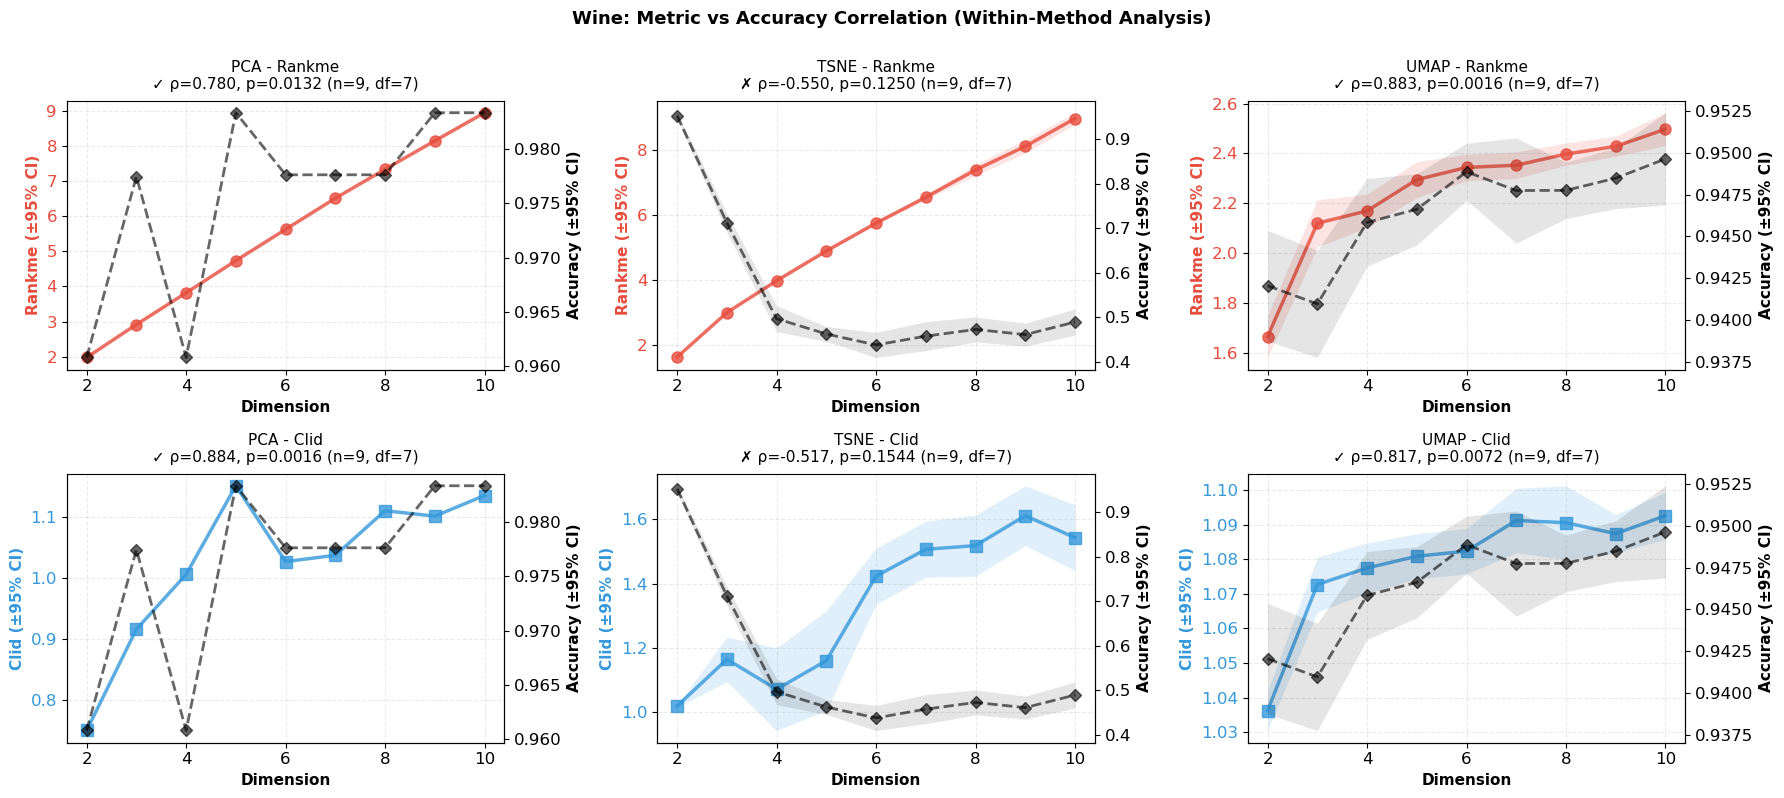

Metric vs Accuracy Scatter Plot
Saved: Wine/Wine_scatter_rankme_both_20251227_185155.png
Saved: Wine/Wine_scatter_rankme_both_20251227_185155.png


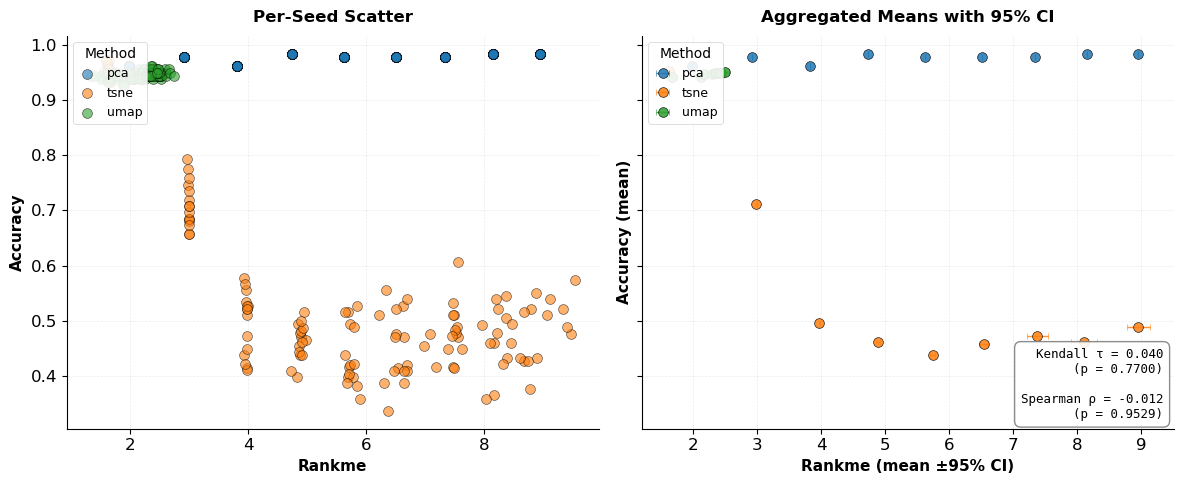

Saved: Wine/Wine_scatter_clid_both_20251227_185156.png


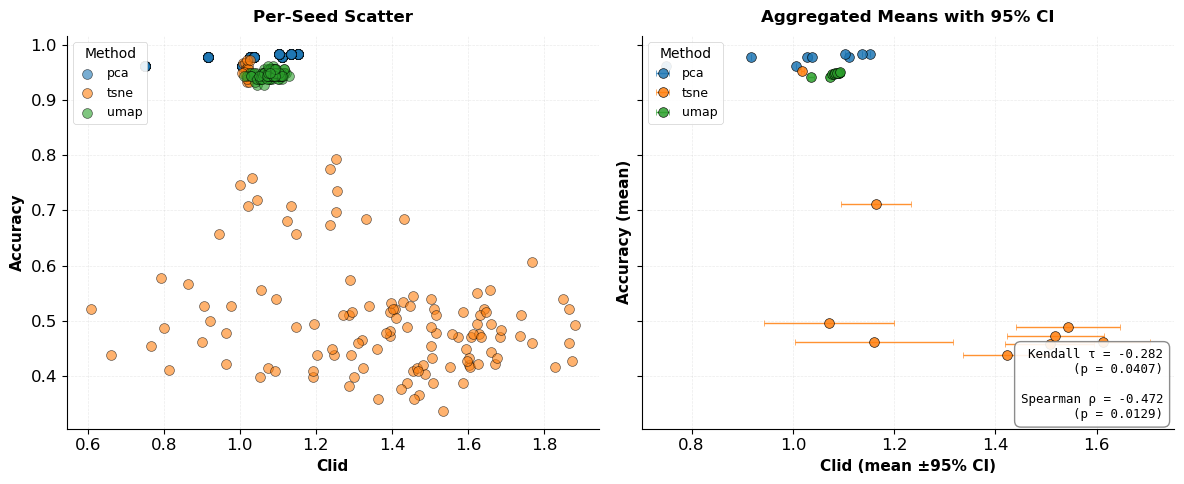

In [377]:
available_datasets = ['Wine']
save_directory = "Wine"
dataset_name = "Wine"

# Run experiments with fixed parameters
evaluation_results, correlation_df = run_with_fixed_parameters(
    reduction_methods=['pca', 'tsne', 'umap'],
    dataset_names=['Wine'],
    n_components_list=[2, 3, 4, 5, 6,7,8,9,10]  # Test different dimensions
)   


# 1. Metric evolution plot 
print(" Metric Evolution Plot")
#visualize_metric_evolution(evaluation_results, save_path=save_directory, eval_metrics=['rankme', 'clid'])

# 2. Correlation evolution plot 
print(" Correlation Evolution Plot")
plot_correlation_evolution(correlation_df, mode='within-method', save_path=save_directory, results=evaluation_results)

# 3. Scatter plot 
print("Metric vs Accuracy Scatter Plot")
plot_metric_vs_accuracy_scatter(evaluation_results,metric='rankme')
plot_metric_vs_accuracy_scatter(evaluation_results,metric='clid')


### 4.5 Experiment with dataset of Breast Cancer

Processing dataset: Breast Cancer
Within-Method Correlation Analysis (Across Dimensions)
✓ Breast Cancer        | PCA   | rankme   | ρ=+0.698 (p=0.0038) | n=15 (df=13)
✗ Breast Cancer        | PCA   | clid     | ρ=-0.099 (p=0.7251) | n=15 (df=13)
✗ Breast Cancer        | TSNE  | rankme   | ρ=+0.232 (p=0.4051) | n=15 (df=13)
✗ Breast Cancer        | TSNE  | clid     | ρ=+0.357 (p=0.1913) | n=15 (df=13)
✗ Breast Cancer        | UMAP  | rankme   | ρ=+0.184 (p=0.5113) | n=15 (df=13)
✗ Breast Cancer        | UMAP  | clid     | ρ=-0.046 (p=0.8694) | n=15 (df=13)
Computed 6 within-method correlations
Within-Method Correlation Analysis (Across Dimensions)
✓ Breast Cancer        | PCA   | rankme   | ρ=+0.698 (p=0.0038) | n=15 (df=13)
✗ Breast Cancer        | PCA   | clid     | ρ=-0.099 (p=0.7251) | n=15 (df=13)
✗ Breast Cancer        | TSNE  | rankme   | ρ=+0.232 (p=0.4051) | n=15 (df=13)
✗ Breast Cancer        | TSNE  | clid     | ρ=+0.357 (p=0.1913) | n=15 (df=13)
✗ Breast Cancer        | UMA

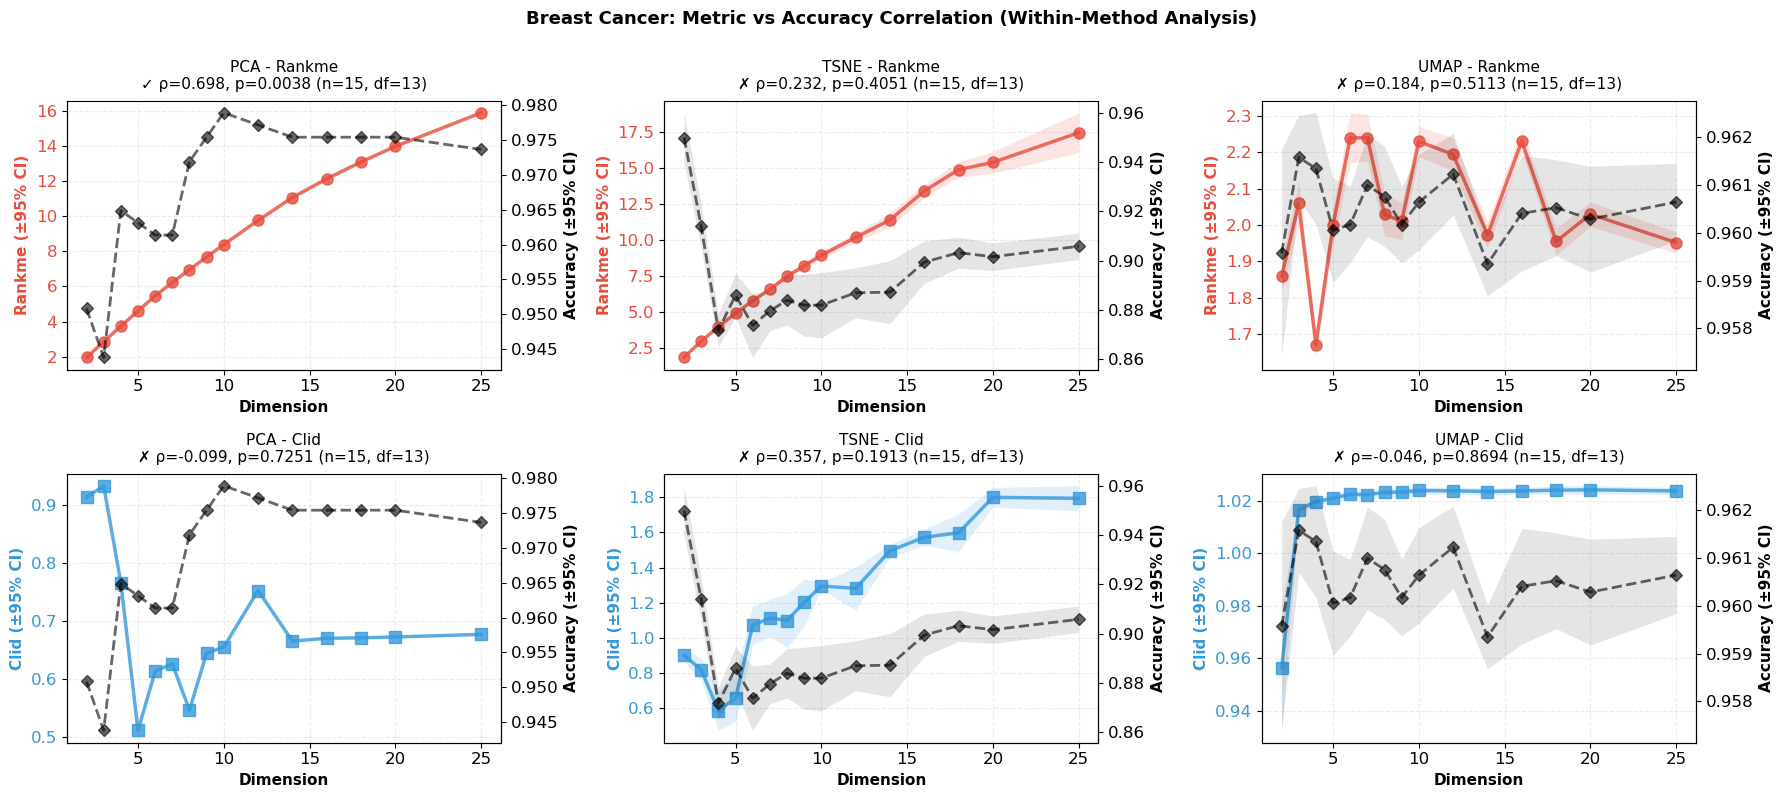

Saved: Breast_Cancer/Breast_Cancer_scatter_rankme_both_20251227_192841.png


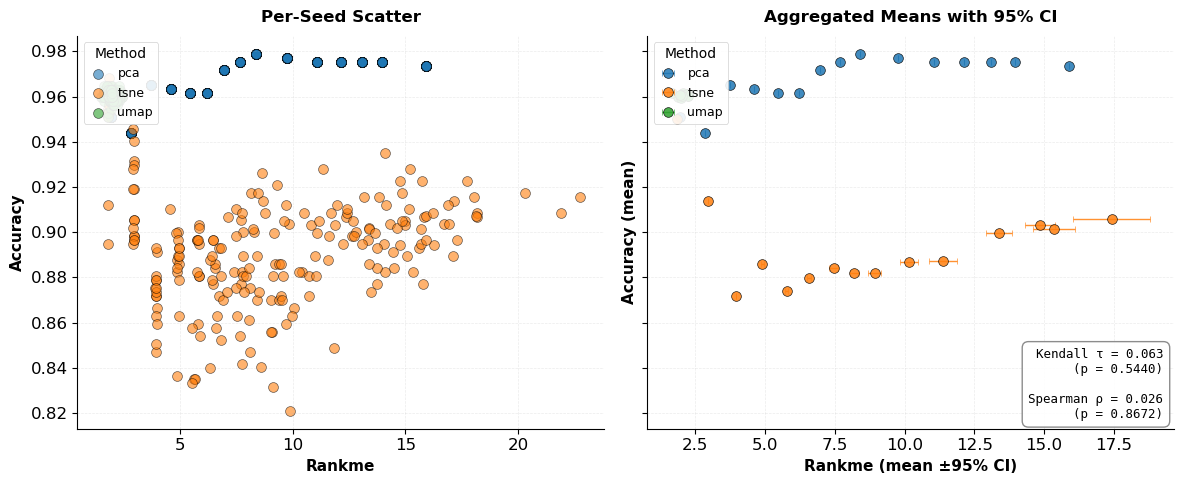

Saved: Breast_Cancer/Breast_Cancer_scatter_clid_both_20251227_192842.png


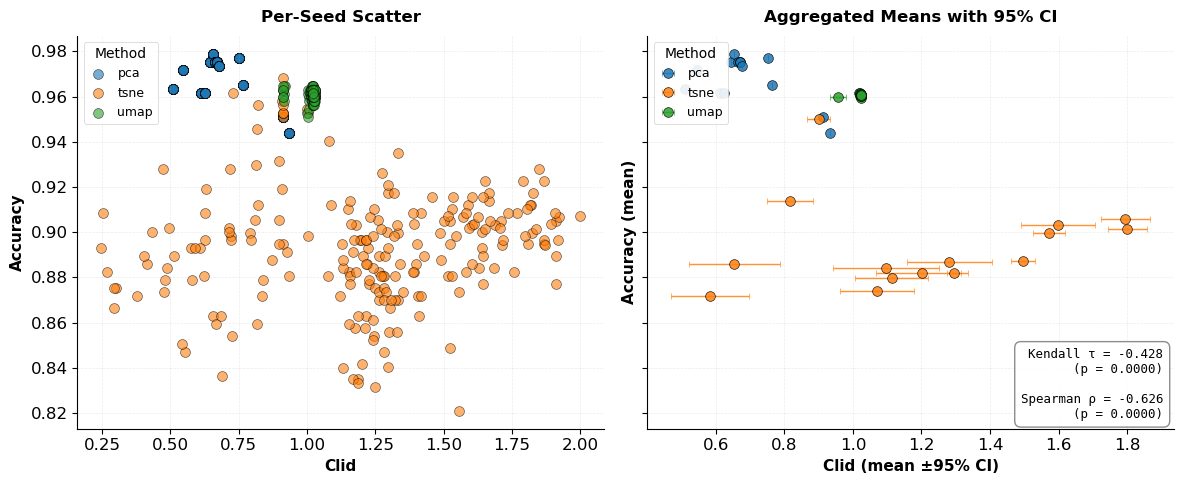

In [378]:
available_datasets = ['Breast Cancer']
save_directory = "Breast_Cancer"
dataset_name = "Breast Cancer"

# Run experiments with fixed parameters
evaluation_results, correlation_df = run_with_fixed_parameters(
    reduction_methods=['pca', 'tsne', 'umap'],
    dataset_names=['Breast Cancer'],
    n_components_list=[2, 3, 4, 5, 6, 7, 8 ,9, 10, 12, 14, 16, 18, 20, 25]  # Test different dimensions
)



# 1. Metric evolution + Correlation + Scatter plots
#visualize_metric_evolution(evaluation_results, save_path=save_directory, eval_metrics=['rankme', 'clid'])
plot_correlation_evolution(correlation_df, mode='within-method', save_path=save_directory, results=evaluation_results)
plot_metric_vs_accuracy_scatter(evaluation_results,metric='rankme')
plot_metric_vs_accuracy_scatter(evaluation_results,metric='clid')



### 4.6 Experiment with dataset of Digits 

Processing dataset: Digits
Within-Method Correlation Analysis (Across Dimensions)
✓ Digits               | PCA   | rankme   | ρ=+0.991 (p=0.0000) | n=14 (df=12)
✗ Digits               | PCA   | clid     | ρ=+0.196 (p=0.5028) | n=14 (df=12)
✓ Digits               | TSNE  | rankme   | ρ=-0.754 (p=0.0018) | n=14 (df=12)
✓ Digits               | TSNE  | clid     | ρ=-0.903 (p=0.0000) | n=14 (df=12)
✗ Digits               | UMAP  | rankme   | ρ=+0.332 (p=0.2464) | n=14 (df=12)
✓ Digits               | UMAP  | clid     | ρ=+0.780 (p=0.0010) | n=14 (df=12)
Computed 6 within-method correlations
Within-Method Correlation Analysis (Across Dimensions)
✓ Digits               | PCA   | rankme   | ρ=+0.991 (p=0.0000) | n=14 (df=12)
✗ Digits               | PCA   | clid     | ρ=+0.196 (p=0.5028) | n=14 (df=12)
✓ Digits               | TSNE  | rankme   | ρ=-0.754 (p=0.0018) | n=14 (df=12)
✓ Digits               | TSNE  | clid     | ρ=-0.903 (p=0.0000) | n=14 (df=12)
✗ Digits               | UMAP  | ra

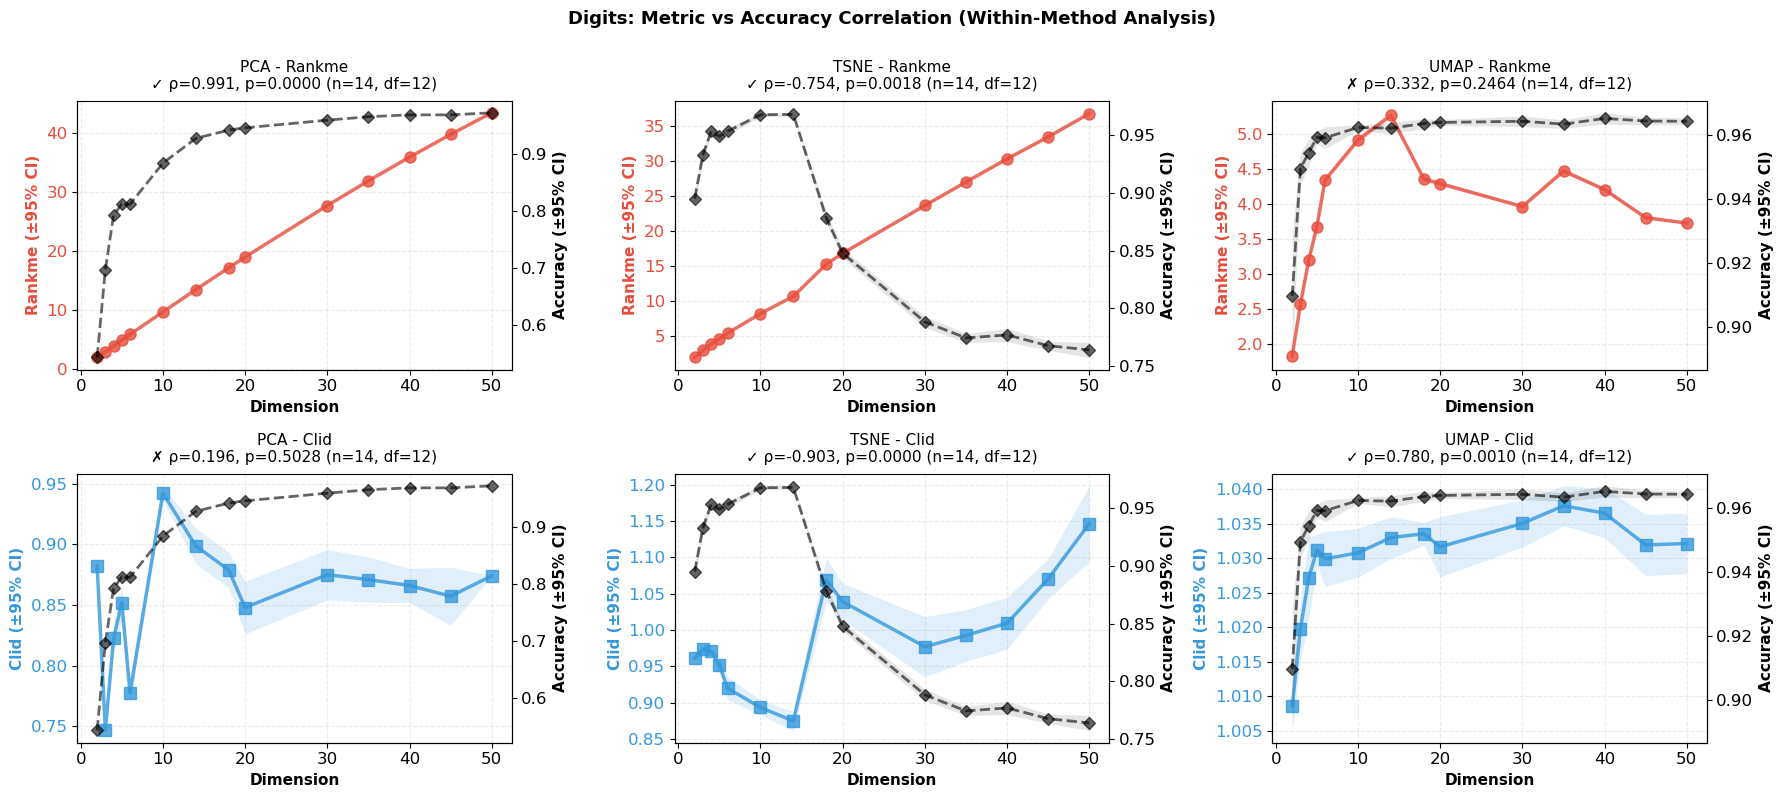

Saved: Digits/Digits_scatter_rankme_both_20251227_233650.png


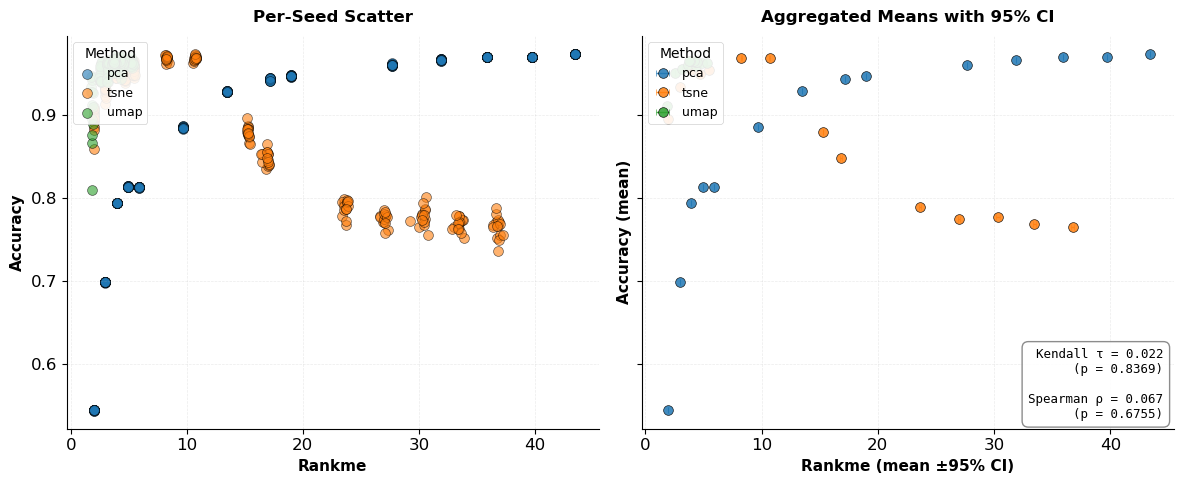

Saved: Digits/Digits_scatter_clid_both_20251227_233651.png


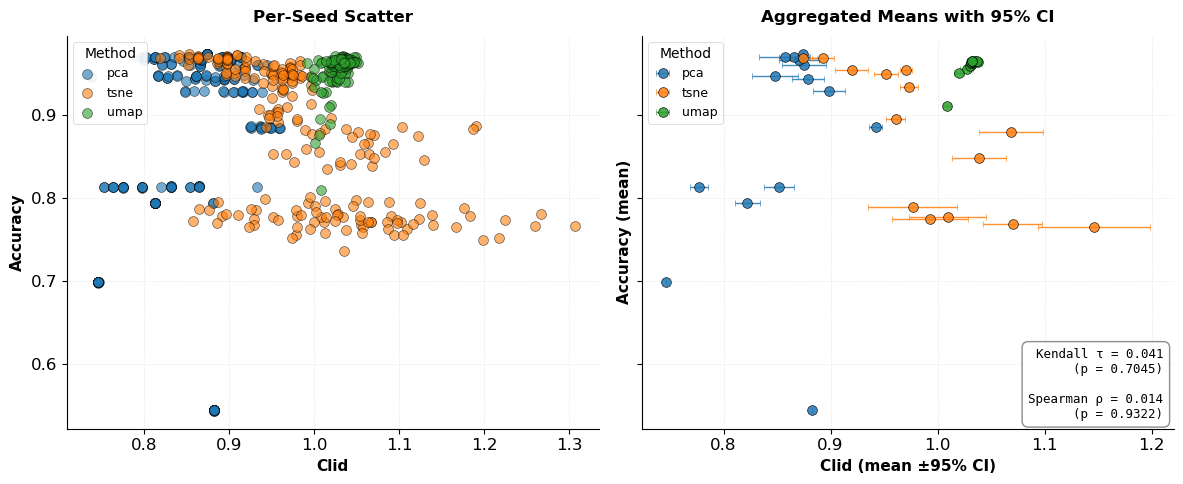

In [379]:

available_datasets = ['Digits']
save_directory = "Digits"
dataset_name = "Digits"

# Run experiments with fixed parameters
evaluation_results, correlation_df= run_with_fixed_parameters(
    reduction_methods=['pca', 'tsne', 'umap'],
    dataset_names=['Digits'],
    n_components_list=[2,  3, 4, 5,  6,  10,  14,  18, 20, 30, 35, 40 ,45, 50]  # Test different dimensions
)
# 1. Evolution plot (like teacher's whiteboard - showing trend with dimensions)
#visualize_metric_evolution(evaluation_results, eval_metrics=['rankme', 'clid'],save_path=save_directory)
plot_correlation_evolution(correlation_df, mode='within-method', save_path="Digits_Correlation_Plots", results=evaluation_results)
plot_metric_vs_accuracy_scatter(evaluation_results,metric='rankme')
plot_metric_vs_accuracy_scatter(evaluation_results,metric='clid')


### 4.7 Experiment with dataset of Olivetti Faces 

Processing dataset: Olivetti Faces
Within-Method Correlation Analysis (Across Dimensions)
✓ Olivetti Faces       | PCA   | rankme   | ρ=+0.878 (p=0.0001) | n=13 (df=11)
✗ Olivetti Faces       | PCA   | clid     | ρ=-0.138 (p=0.6527) | n=13 (df=11)
✓ Olivetti Faces       | TSNE  | rankme   | ρ=-0.577 (p=0.0390) | n=13 (df=11)
✗ Olivetti Faces       | TSNE  | clid     | ρ=-0.060 (p=0.8445) | n=13 (df=11)
✗ Olivetti Faces       | UMAP  | rankme   | ρ=+0.005 (p=0.9858) | n=13 (df=11)
✗ Olivetti Faces       | UMAP  | clid     | ρ=+0.456 (p=0.1173) | n=13 (df=11)
Computed 6 within-method correlations
Within-Method Correlation Analysis (Across Dimensions)
✓ Olivetti Faces       | PCA   | rankme   | ρ=+0.878 (p=0.0001) | n=13 (df=11)
✗ Olivetti Faces       | PCA   | clid     | ρ=-0.138 (p=0.6527) | n=13 (df=11)
✓ Olivetti Faces       | TSNE  | rankme   | ρ=-0.577 (p=0.0390) | n=13 (df=11)
✗ Olivetti Faces       | TSNE  | clid     | ρ=-0.060 (p=0.8445) | n=13 (df=11)
✗ Olivetti Faces       | UM

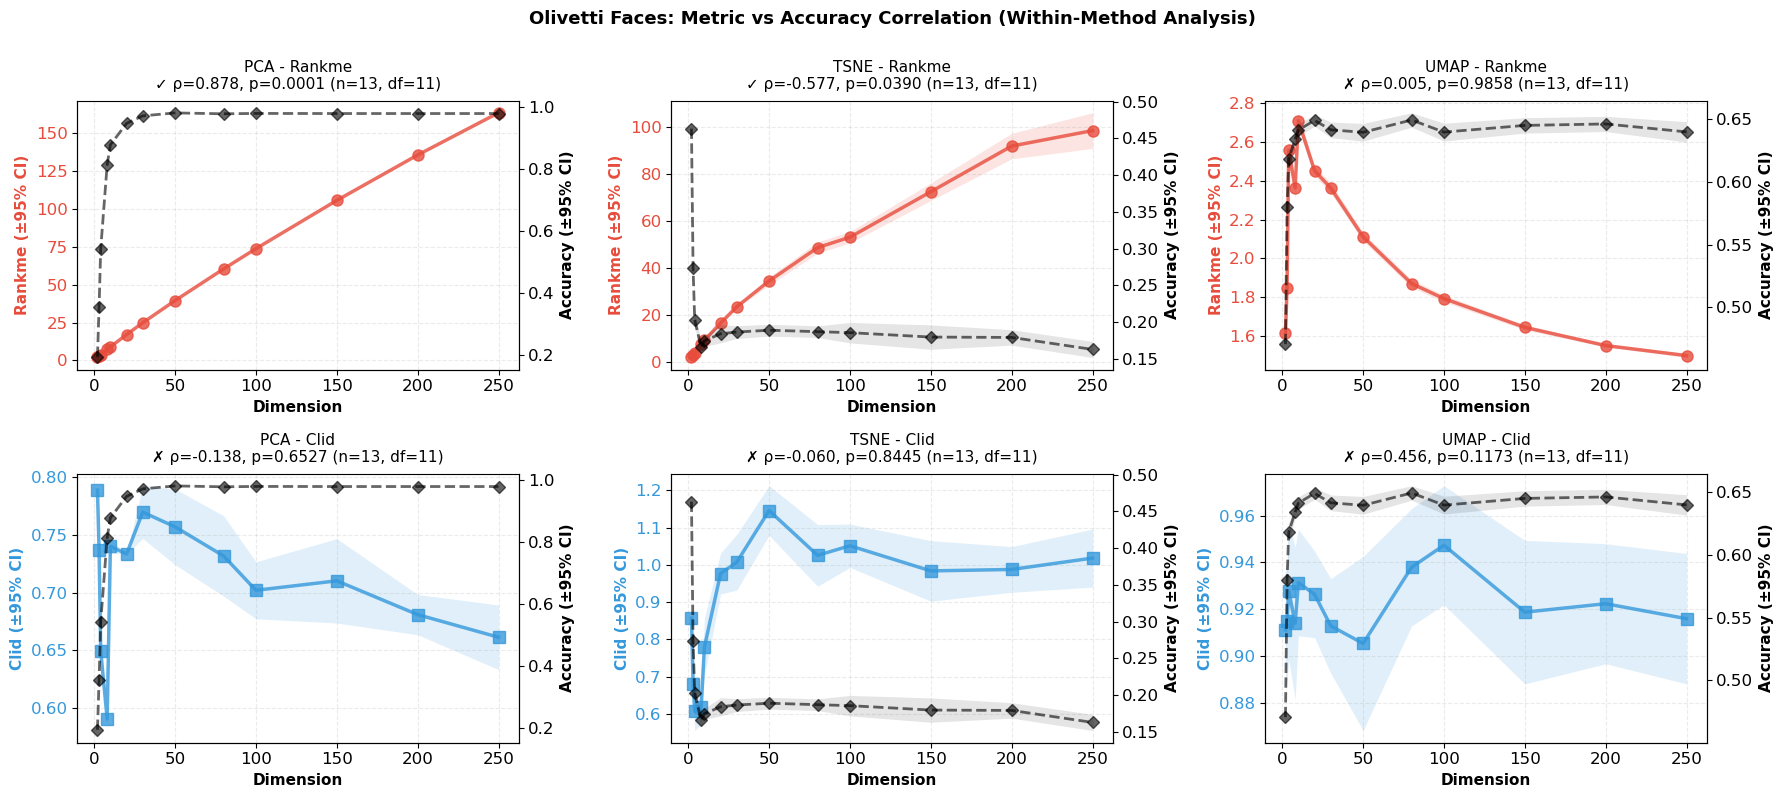

Saved: Olivetti_Faces/Olivetti_Faces_scatter_rankme_both_20251228_001951.png


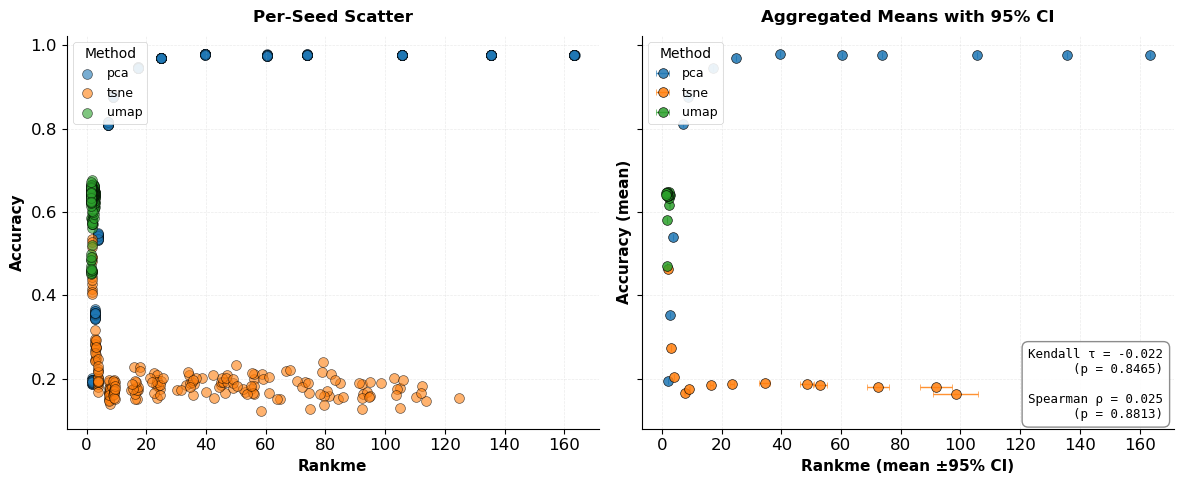

Saved: Olivetti_Faces/Olivetti_Faces_scatter_clid_both_20251228_001951.png


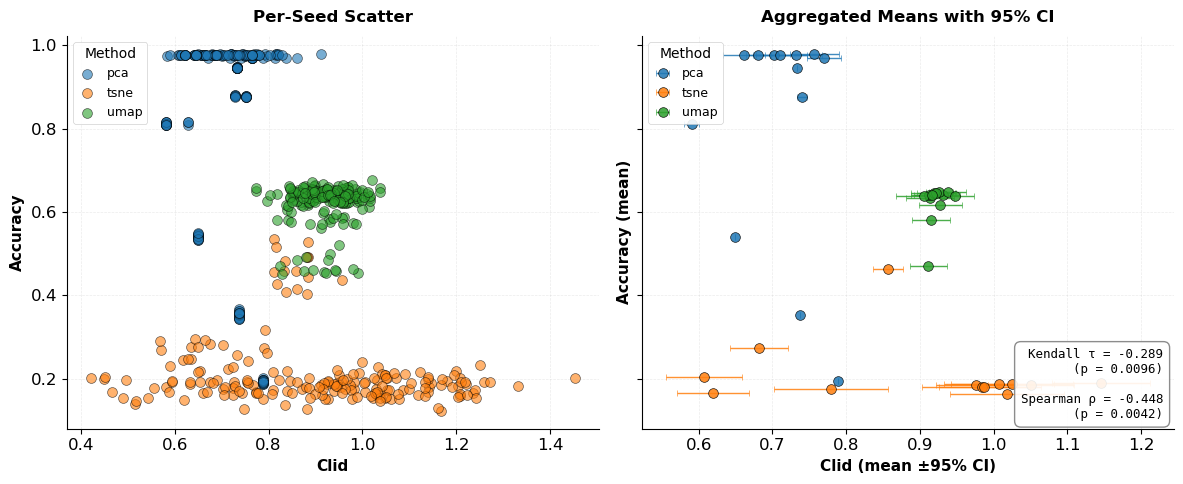

In [380]:

available_datasets = ['Olivetti Faces']
save_directory = 'Olivetti Faces'
dataset_name = 'Olivetti Faces'

# Run experiments with fixed parameters
evaluation_results, correlation_df= run_with_fixed_parameters(
    reduction_methods=['pca', 'tsne', 'umap'],
    dataset_names=['Olivetti Faces'],
    n_components_list=[2,  3,  4, 8, 10, 20, 30, 50, 80, 100, 150, 200, 250]  # Test different dimensions
)

# 1. Evolution plot (like teacher's whiteboard - showing trend with dimensions)
#(evaluation_results, save_path=save_directory)
plot_correlation_evolution(correlation_df, mode='within-method', save_path=save_directory, results=evaluation_results)
plot_metric_vs_accuracy_scatter(evaluation_results,metric='rankme')
plot_metric_vs_accuracy_scatter(evaluation_results,metric='clid')


## 5 Conclusion and Future work

## 5.1 Conclusion

Among all tested combinations of metrics and methods, **RankMe shows strong, consistent correlation with classification accuracy specifically when using PCA** especially in the dataset Olivetti Faces while showing weak or inconsistent correlations with t-SNE and UMAP.





## Smoke Test

Quick validation test using a small dataset (Iris) with minimal seeds and dimensions. Use this cell to verify that all functions work correctly after making code changes.

**Purpose**: 
- Fast execution (< 1 minute)
- Tests full pipeline: data loading → DR → metrics → plotting
- Catches errors early before running expensive experiments

**Usage**: Run this cell after modifying core functions (rankme, clid, plotting, etc.) to ensure nothing is broken.

In [381]:
# Smoke Test: Quick validation with Iris dataset
print("=" * 80)
print("SMOKE TEST: Quick Pipeline Validation")
print("=" * 80)
print("\nDataset: Iris")
print("Methods: PCA, t-SNE, UMAP")
print("Dimensions: [2, 3, 5]")
print("Seeds: 3 (for speed)")
print("Expected runtime: < 1 minute")
print("-" * 80)

# Temporarily override random seeds for fast testing
original_seeds = RANDOM_STATE_LIST.copy()
SMOKE_TEST_SEEDS = [42, 100, 200]  # Only 3 seeds for speed

# Backup and override
temp_random_state_list = RANDOM_STATE_LIST
RANDOM_STATE_LIST = SMOKE_TEST_SEEDS

try:
    # Run smoke test
    print("\n[1/3] Running experiments...")
    smoke_results, smoke_corr = run_with_fixed_parameters(
        reduction_methods=['pca', 'tsne', 'umap'],
        dataset_names=['Iris'],
        n_components_list=[2, 3, 5],  # Only test 3 dimensions
        random_state_list=SMOKE_TEST_SEEDS
    )
    
    print("\n[2/3] Generating plots...")
    # Test plotting functions

    plot_correlation_evolution(smoke_corr, mode='within-method', save_path="smoke_test", results=smoke_results)
    
    print("\n[3/3] Checking results...")
    # Validate results
    df_smoke = pd.DataFrame(smoke_results)
    
    # Check for required columns
    required_cols = ['dataset', 'method', 'n_components', 'accuracy', 'rankme', 'clid']
    missing_cols = [col for col in required_cols if col not in df_smoke.columns]
    if missing_cols:
        print(f"FAILED: Missing columns: {missing_cols}")
    else:
        print(f"All required columns present")
    
    # Check for data
    total_rows = len(df_smoke)
    expected_rows = 3 * 3 * 3  # 3 methods × 3 dims × 3 seeds
    print(f"Generated {total_rows} data points (expected ~{expected_rows})")
    
    # Check for NaN values
    nan_counts = df_smoke[required_cols].isna().sum()
    if nan_counts.sum() > 0:
        print(f"Warning: Some NaN values detected:")
        for col, count in nan_counts[nan_counts > 0].items():
            print(f"   - {col}: {count} NaNs")
    else:
        print(f"No NaN values in key metrics")
    
    # Show sample results
    print(f"\Sample results (first 5 rows):")
    print(df_smoke[['dataset', 'method', 'n_components', 'accuracy', 'rankme', 'clid']].head())
    
    print("\n" + "=" * 80)
    print("SMOKE TEST PASSED - Pipeline is working correctly!")
    print("=" * 80)
    
except Exception as e:
    print("\n" + "=" * 80)
    print(f"SMOKE TEST FAILED")
    print("=" * 80)
    print(f"\nError: {type(e).__name__}")
    print(f"Message: {str(e)}")
    import traceback
    print("\nFull traceback:")
    traceback.print_exc()
    
finally:
    # Restore original seeds
    RANDOM_STATE_LIST = temp_random_state_list
    print(f"\n✓ Restored original random seeds ({len(RANDOM_STATE_LIST)} seeds)")


SMOKE TEST: Quick Pipeline Validation

Dataset: Iris
Methods: PCA, t-SNE, UMAP
Dimensions: [2, 3, 5]
Seeds: 3 (for speed)
Expected runtime: < 1 minute
--------------------------------------------------------------------------------

[1/3] Running experiments...
Processing dataset: Iris
Within-Method Correlation Analysis (Across Dimensions)
⚠️  Skipping Iris/pca: only 2 dimensions
⚠️  Skipping Iris/tsne: only 2 dimensions
⚠️  Skipping Iris/umap: only 2 dimensions
Computed 0 within-method correlations

[2/3] Generating plots...

SMOKE TEST FAILED

Error: ValueError
Message: No correlation data available for plotting.

Full traceback:

✓ Restored original random seeds (15 seeds)
Within-Method Correlation Analysis (Across Dimensions)
⚠️  Skipping Iris/pca: only 2 dimensions
⚠️  Skipping Iris/tsne: only 2 dimensions
⚠️  Skipping Iris/umap: only 2 dimensions
Computed 0 within-method correlations

[2/3] Generating plots...

SMOKE TEST FAILED

Error: ValueError
Message: No correlation data ava

Traceback (most recent call last):
  File "/var/folders/6n/q_rng36s2vx21yvdlfr34pd40000gn/T/ipykernel_2308/313136454.py", line 33, in <module>
    plot_correlation_evolution(smoke_corr, mode='within-method', save_path="smoke_test", results=smoke_results)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/6n/q_rng36s2vx21yvdlfr34pd40000gn/T/ipykernel_2308/3222142628.py", line 19, in plot_correlation_evolution
    raise ValueError("No correlation data available for plotting.")
ValueError: No correlation data available for plotting.
